# Notebook para o PAN - Atribuição Autoral - 2018

In [203]:
%matplotlib inline
#python basic libs
import os;
from os.path import join as pathjoin;

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

import re;
import json;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler;
from sklearn import preprocessing;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score;

In [2]:
import seaborn as sns;
sns.set(color_codes=True);

In [3]:
import zipfile
import gensim
import nltk
from gensim.models import KeyedVectors
import logging
 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [4]:
import platform;
import sklearn;
import scipy;
import spacy;
import gensim;

print("|%-15s|%-40s|"%("PACK","VERSION"))
print("|%-15s|%-40s|"%('-'*15,'-'*40))
print('\n'.join(
    "|%-15s|%-40s|" % (pack, version)
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','Seaborn','Spacy','Gensim','NLTK'],
        [platform.platform(), np.__version__, scipy.__version__,
         sklearn.__version__, sns.__version__, spacy.__version__, gensim.__version__, nltk.__version__])

))

|PACK           |VERSION                                 |
|---------------|----------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit         |
|NumPy          |1.15.4                                  |
|SciPy          |1.1.0                                   |
|Scikit-Learn   |0.20.1                                  |
|Seaborn        |0.9.0                                   |
|Spacy          |2.0.16                                  |
|Gensim         |3.4.0                                   |
|NLTK           |3.4                                     |


In [5]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

### paths configuration

### on google

from google.colab import drive
drive.mount('/gdrive')

!ls '/gdrive/My Drive/data_repository'

baseDir = '/gdrive/My Drive/data_repository';
modelName = 'char1';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',modelName);

os.makedirs(outputDir, exist_ok=True)


def transferCode(filename):
    with open(os.path.join('/gdrive/My Drive','Colab Notebooks',filename)) as fin:
        with open(filename,'w') as fout:
            fout.write(fin.read());

transferCode('pan.py')
transferCode('sklearnExtensions.py')

!ls 

In [6]:
### on local

In [7]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## Data Ingestion

In [8]:
import pan
import sklearnExtensions
from sklearnExtensions import DenseTransformer
from sklearnExtensions import POSTagTransformer

In [9]:
problems = pan.readCollectionsOfProblems(inputDir);

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[[graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[[after all, his best friends. And what in the..."
1,"[[a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[[“Potter was attractive,” Draco thought, sigh..."
2,[[qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[[son réveil. Sa main pulse et Draco frotte l'...
3,[[. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[[abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[[Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[[– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[[Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[[così la tua vista, Moony?\n– Cercavo di esse..."
6,[[zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[[dawniej pełna radości i ciepła, a teraz wiec..."
7,"[[Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[[, uderzającego o żebra niczym dzwon- niemal ..."
8,[[pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[[–La nariz puntiaguda del elfo casi rozaba el...
9,"[[incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[[tan parecidas hizo que su trasero latiese de...


In [11]:
def problemDoc(problem):
    train_docs, train_labels, _   = zip(*problem['candidates'])
    test_docs, _, test_filename   = zip(*problem['unknown']);
    test_labels = pan.readGroundTruh(pathjoin(inputDir, problem['problem'], 'ground-truth.json'),test_filename)
    return train_docs, train_labels, test_docs, test_labels,test_filename;

In [12]:
problem = problems[0]
train_docs, train_labels, test_docs, test_labels,_ = problemDoc(problem)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    train_docs, train_labels,
    test_size=0.33,
    stratify=train_labels,
    random_state=42)

In [14]:
def builprofile(x,y):
    profile = {};
    for x1,y1 in zip(x,y):
        if y1 not in profile:
            profile[y1] = [];
        profile[y1].append(x1);
    return profile;

In [15]:
profileTrain = builprofile(X_train,y_train)

In [163]:
from collections import Counter

In [390]:
vocab = Counter(list(''.join(X_train)))
vocab = vocab.most_common(int(len(vocab)*0.99))
vocab = [v[0] for v in vocab if v[1] > 5]
print(vocab)

[' ', 'e', 't', 'a', 'o', 'n', 's', 'h', 'i', 'r', 'd', 'l', 'u', 'g', 'm', 'w', 'c', 'y', 'f', '.', '\n', 'p', ',', 'b', 'k', 'v', '"', "'", '\xa0', 'I', 'S', '’', 'H', 'T', 'A', '“', '”', '?', 'W', 'j', '-', 'x', 'B', 'D', 'Y', 'L', 'R', 'M', 'J', 'C', 'N', 'z', 'G', 'q', 'O', 'K', 'E', '!', 'P', 'F', 'Z', ';', '*', '\t', '…', 'U', '–', '—', 'Q', '~', ':', 'V', '(', ')', '1', '‘', '2', '0', '3', 'é', '―', '6', '4', '5', '8', '7', '_']


In [391]:
for k,v in profileTrain.items():
    print(k,set(''.join(v))-set(vocab))

candidate00007 {'X'}
candidate00014 set()
candidate00019 {'&'}
candidate00017 {'»'}
candidate00020 {'á', 'É', 'í', 'ó'}
candidate00010 set()
candidate00005 {'ï'}
candidate00002 {'ü'}
candidate00011 {'#'}
candidate00009 set()
candidate00018 {'à'}
candidate00004 set()
candidate00012 set()
candidate00001 {'9', '/'}
candidate00003 set()
candidate00006 {'9', '/'}
candidate00016 set()
candidate00008 {'X'}
candidate00015 {'ç'}
candidate00013 set()


In [392]:
class DocumentToCharIterator(object):
    def __init__(self, documents,vocab):
        self.documents = documents
        self.vocab = vocab
 
    def __iter__(self):
        for doc in self.documents:
            for sent  in nltk.sent_tokenize(doc):
                sent = list(sent);
                sent = [w for w in sent if w in self.vocab]
                yield sent;

In [393]:
def runW2v(docs,vocab):
    embeddSize = int(len(vocab)/8)*4;
    #embeddSize = 5;
    model = gensim.models.Word2Vec(
                DocumentToCharIterator(docs,vocab),
                size=embeddSize,
                window=5,
                sg=1,
                min_count=20,
                alpha=10.0,
                min_alpha=0.0001,
                iter=50,
                seed=10,
                workers=10)

    mat = np.zeros((len(vocab),embeddSize))
    for i, c in enumerate(vocab):
        if c in model.wv:
            mat[i]= model.wv[c];
    return mat;

In [394]:
def builModel(profiles, vocab):
    pModel = {};
    for k,docs in profiles.items():
        print(k, end=' ')
        pModel[k]= runW2v(docs,vocab);
    return pModel;

In [377]:
profileTrainModel = builModel(profileTrain,vocab)

candidate00007 candidate00014 candidate00019 candidate00017 candidate00020 candidate00010 candidate00005 candidate00002 candidate00011 candidate00009 candidate00018 candidate00004 candidate00012 candidate00001 candidate00003 candidate00006 candidate00016 candidate00008 candidate00015 candidate00013 

In [378]:
valmodel = {i:[doc] for i,doc in enumerate(X_val)}
valmodel = builModel(valmodel,vocab)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

In [379]:
from scipy.spatial import distance

In [380]:
def matSim(matA,matB,simFunc):
    sim = 0;
    for i, row in enumerate(matA):
        s = simFunc(row,matB[i,:]);
        if not np.isnan(s):
            sim += s;
        
    return sim;

In [381]:
def documentDist(docsModel,authModel):
    docSize = max(docsModel.keys())+1;
    keys = sorted(authModel.keys());
    authSize = len(keys);
    result = np.zeros((docSize, authSize),dtype=np.float32);
    for i in range(docSize):
        for j,k2 in enumerate(keys):
            result[i,j] = matSim(docsModel[i],authModel[k2],distance.cosine);
    return result;

In [382]:
valResult = documentDist(valmodel,profileTrainModel)

/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [383]:
def cleanCandidates(v):
    return np.array([re.sub('\D0*','',y) for y in v])

In [384]:
pred = np.array(sorted(profileTrainModel.keys()))[np.argmin(valResult,axis=1)]

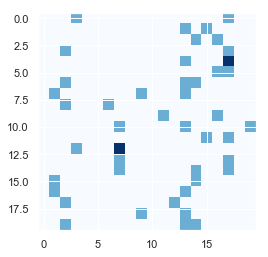

In [385]:
plt.imshow(confusion_matrix(y_val,pred),cmap=plt.cm.Blues)

In [386]:
def percentZeros(mat):
    return np.sum(mat ==0)/(mat.shape[0]*mat.shape[1])

In [387]:
zeros = [percentZeros(profileTrainModel[k]) for k in profileTrainModel];


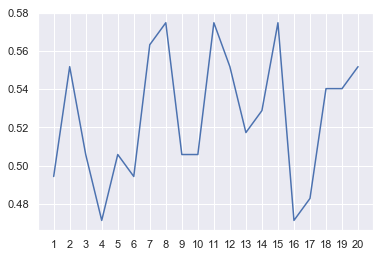

In [388]:
plt.plot(cleanCandidates(sorted(profileTrainModel.keys())),zeros)

In [389]:
df = pd.DataFrame(data=preprocessing.normalize(valResult),
             columns=cleanCandidates(sorted(profileTrainModel.keys())),
             index=cleanCandidates(y_val)
            )
df['max']=np.argmax(valResult,axis=1)
df.reset_index(inplace=True)
df.style.background_gradient(axis=1, subset=cleanCandidates(sorted(profileTrainModel.keys())), cmap=plt.cm.Blues_r)

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,max
0,6,0.232038,0.194672,0.223598,0.251387,0.214174,0.183035,0.259308,0.194389,0.241322,0.225525,0.25026,0.204167,0.224001,0.243791,0.191872,0.230472,0.221388,0.17433,0.237912,0.248411,6
1,17,0.236736,0.202209,0.219209,0.220476,0.240941,0.216714,0.209143,0.200176,0.211678,0.219372,0.25579,0.22794,0.220274,0.189514,0.248951,0.260186,0.238949,0.191865,0.207202,0.237296,15
2,11,0.214766,0.214881,0.218757,0.225604,0.222449,0.24277,0.225498,0.200218,0.202977,0.25583,0.216854,0.212775,0.215734,0.229029,0.237185,0.221836,0.232429,0.216603,0.233319,0.225398,9
3,18,0.229943,0.193589,0.232362,0.210594,0.233984,0.221782,0.232773,0.238535,0.230472,0.199968,0.225434,0.233788,0.190256,0.215869,0.198278,0.233282,0.236846,0.240568,0.237075,0.225839,17
4,6,0.22753,0.189864,0.207342,0.261047,0.248134,0.20344,0.260667,0.172478,0.233404,0.259557,0.248041,0.204346,0.244137,0.257956,0.204923,0.208184,0.152928,0.188264,0.224047,0.234001,3
5,13,0.224245,0.225534,0.215192,0.205427,0.222779,0.223777,0.221537,0.161323,0.22835,0.257249,0.243343,0.214852,0.248673,0.223426,0.228699,0.240402,0.246707,0.191918,0.246924,0.176945,9
6,7,0.232821,0.226627,0.177087,0.212318,0.205235,0.19814,0.230161,0.197841,0.21248,0.247803,0.239726,0.201921,0.241703,0.253769,0.198112,0.251494,0.237341,0.216559,0.230127,0.241249,13
7,7,0.235997,0.242497,0.207697,0.191487,0.23661,0.222313,0.183767,0.22319,0.200705,0.243385,0.235447,0.229408,0.244251,0.153672,0.232355,0.244583,0.250137,0.220956,0.225996,0.222653,16
8,5,0.243096,0.219357,0.24451,0.211342,0.232425,0.208127,0.208065,0.221255,0.224033,0.231392,0.207627,0.245271,0.221975,0.201686,0.233701,0.252347,0.221761,0.214982,0.205733,0.213978,15
9,10,0.230194,0.239513,0.222556,0.224132,0.235749,0.231699,0.228087,0.208512,0.216751,0.231534,0.226125,0.212811,0.236096,0.21462,0.232749,0.208109,0.204338,0.225305,0.218586,0.22028,1


In [ ]:
w2v_repository = '/Users/joseeleandrocustodio/Downloads/w2v_repository/'
embeddingsFiles = {
    'it':'w2v Italian CoNLL17 corpus.zip',
    'fr':'w2v French CoNLL17 corpus.zip',
    'de':'w2v Dutch CoNLL17 corpus.zip',
    'pl':'w2v Polish CoNLL17 corpus.zip',
    'it':'w2v Italian CoNLL17 corpus.zip',
    'es': 'w2v Spanish CoNLL17 corpus.zip',
    #'en':'GoogleNews-vectors-negative300.bin.gz'
}

In [ ]:
def problemsToTokens():
    tokens = {};
    pattern = re.compile(r"(?u)\b\w\w+\b");
    for problem in problems:
        lang = problem['language'];
        if lang == 'sp':
            lang = 'es';
        train_docs, _, test_docs, _, _ = problemDoc(problem);
        docs = list(train_docs)+list(test_docs);

        if lang not in tokens:
            tokens[lang] = list();
        tokens[lang] +=list(set([w  for d in docs for w in pattern.findall(d)]));
        tokens[lang] = sorted(list(set(tokens[lang])));
    return tokens;

#http://vectors.nlpl.eu/repository/#
def buildTruncatedW2vFile(taggingVersion='w2v'):
    if not os.path.exists('embedding_cache'):
        os.makedirs('embedding_cache');
    
    tokens = problemsToTokens();
    for lang, words in tokens.items():
        if lang not in embeddingsFiles:
            continue;
        print(lang);

        w2vfile = os.path.join(w2v_repository,embeddingsFiles[lang]);
        
        selectedLines = [];
        lineappend=selectedLines.append;
        t0 = time();
        with zipfile.ZipFile(w2vfile, "r") as archive:
            stream = archive.open("model.txt");
            embeddingSize = stream.readline().decode('utf-8').split(' ')[1]
            for line in stream:
                line= line.decode('utf-8','replace')
                (firstWord, rest) = line.split(maxsplit=1);
                for w in [firstWord,firstWord.lower(),firstWord.capitalize(), firstWord.upper()]:
                    if w in words:
                        lineappend(line);
                        words.remove(w);
                        break;
                    
                if len(words) ==0:
                    break;
        print("Model loaded in %0.3fs" % (time() - t0))
        t0 = time();
        filename = os.path.join('embedding_cache',taggingVersion+'_'+lang+'.zip');
        with zipfile.ZipFile(filename, "w") as archive:
            selectedLines = [str(len(selectedLines))+" "+embeddingSize] + selectedLines;
            archive.writestr("mode.txt", ''.join(selectedLines))
        print("Model save in %0.3fs" % (time() - t0))
#buildTruncatedW2vFile();

In [ ]:
def buildTruncatedW2vFileEnglish(taggingVersion='w2v'): 
    w2vmodel = KeyedVectors.load_word2vec_format(os.path.join(w2v_repository,'GoogleNews-vectors-negative300.bin.gz'),binary=True);
    if not os.path.exists('embedding_cache'):
        os.makedirs('embedding_cache');
    
    tokens = problemsToTokens();
    lang = 'en';
    words = tokens['en'];
    print(lang);
    selectedLines = [];
    lineappend=selectedLines.append;
    loaded = [];
    t0 = time()
    for w in set(words):
        for w2 in [w, w.lower(), w.capitalize(), w.upper()]:
            if w2 in w2vmodel and w2 not in loaded:
                vector = w2vmodel[w2]
                lineappend(w2 +' '+' '.join(["%s"%n for n in vector]));
                loaded.append(w2);
                
    embeddingSize = str(len(vector))

    print("Model loaded in %0.3fs" % (time() - t0))
    t0 = time();
    filename = os.path.join('embedding_cache',taggingVersion+'_'+lang+'.zip');
    with zipfile.ZipFile(filename, "w") as archive:
        selectedLines = [str(len(selectedLines))+" "+embeddingSize] + selectedLines;
        archive.writestr("mode.txt", '\n'.join(selectedLines))
    print("Model save in %0.3fs" % (time() - t0))
    import gc;
    print("GC "+str(gc.collect()))

In [ ]:
buildCache = False;
if buildCache:
    buildTruncatedW2vFileEnglish();
    buildTruncatedW2vFile();

In [ ]:
def loadModel(lang):
    if lang == 'sp':
        lang = 'es';

    with zipfile.ZipFile(os.path.join('embedding_cache','w2v_'+lang+'.zip'),'r') as archive:
        model = KeyedVectors.load_word2vec_format(archive.open("mode.txt"), binary=False, unicode_errors='replace')
    return model;

In [ ]:
from sklearn import preprocessing

In [ ]:
embeddingsCache = None;

### analisando os demais parametros

In [ ]:
from scipy import sparse

class EmbeddingVectorizer(BaseEstimator):
    def __init__(self,norm=None,analyzer='word',min_df=1,lowercase=False,sublinear_tf=True,use_idf=True):
        self.norm        = norm;
        self.analyzer    = analyzer;
        self.min_df      = min_df;
        self.lowercase   = lowercase;
        self.sublinear_tf= sublinear_tf;
        self.use_idf     = use_idf;
        
    def fit(self, X, y=None):
        self.dim_ = len(embeddingsCache.vectors[0]);
        #self.dim_ = len(embeddingsCache[list(embeddingsCache.keys())[0]])
        self.vect = TfidfVectorizer(**self.get_params())
        self.vect.fit(X,y);
        self.word_vectors_ = np.zeros((len(self.vect.vocabulary_), self.dim_));
        
        blank = np.zeros(self.dim_);

        for  word, index in self.vect.vocabulary_.items():
            temp = blank.copy();
            for w in [word, word.lower(), word.capitalize()]:
                if w in embeddingsCache:
                    temp = embeddingsCache[w];
                    break;
            self.word_vectors_[index,:] = temp;
        return self
    
    def transform(self, X):
        import gc;
        gc.collect()
        X = self.vect.transform(X);
        #memory friendly dot product
        X = sparse.csc_matrix(X);
        V = sparse.csc_matrix(self.word_vectors_);
        return X.dot(V)/X.sum(axis=1);
    
    def fit_transform(self, X, y=None):
        self.fit(X,y);
        return self.transform(X)
    
    def get_feature_names():
        return self.vect.get_feature_names();

In [ ]:
def runML(problem):
    import gc;
    gc.collect();
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']));
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    t0 = time()
    
    global embeddingsCache;
    embeddingsCache = loadModel(problem['language'])
    
    pipeline = Pipeline([
        ('vect', EmbeddingVectorizer(
                analyzer='word',
                min_df=0.01,
                lowercase=False,
                norm='l1',
                sublinear_tf=True
                )
        ),
        #('scaler',preprocessing.RobustScaler(with_centering=False,quantile_range=(1.0,99.0))),
        ('scaler',preprocessing.MaxAbsScaler()),
        ('pca',PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df':(0.01,5,10,0.1),
        'vect__sublinear_tf':(True,False),
        'vect__use_idf':(True,False),
        'clf__C':(0.01,0.1,1),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=3,
                               iid=False,
                               n_jobs=2,
                               verbose=True,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #calculating the performance using PAN evaluation code
    f1,precision,recall,accuracy=pan.evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [ ]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
with warnings.catch_warnings():
    warnings.filterwarnings("ignore");
    for problem in problems:
        i = int(re.sub('\D+','',problem['problem']));
        r, c, b, e = runML(problem);
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);
os.system( "say finished" )

In [ ]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [ ]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [ ]:
df

In [ ]:
print(df[["macro-f1"]].reset_index().to_latex(index=False).replace("     "," "))

In [ ]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [ ]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = result[i]['problem-name'];
    temp['language'] = languages[result[i]['language']]
    dfCV = dfCV.append(temp);

for p in [
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_clf__C',
    'param_vect__min_df',
    'param_vect__sublinear_tf',
    'param_vect__use_idf',
    'mean_test_score',   
    'std_test_score',
    'mean_train_score',   

    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_clf__C':'regularization',
    'param_vect__min_df':'min_df',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__use_idf':'use_idf'
},inplace=True);

def nrange(x):
    return sum([i for i in range(x+1)])

#print('\',\n\''.join(dfCV.columns))

In [ ]:
dfCV.to_csv('PANAA2018_Embeddings.csv', index=False)

In [ ]:
dfCV = pd.read_csv('PANAA2018_Embeddings.csv', na_values='')

In [ ]:
(dfCV[dfCV.rank_test_score == 1])[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
]
].sort_values(by=[
    'problem',
    'mean_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
], ascending=[True, False,True,True, True,True]).head(10)

In [ ]:
dfCV.pivot_table(
            index=['problem','language'],
            columns=['regularization','sublinear_tf','use_idf'],
            values='mean_test_score'
        ).style.background_gradient(cmap=plt.cm.Blues)

In [ ]:
(dfCV)[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
]
].sort_values(by=[
    'problem',
    'mean_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
], ascending=[True, False,True,True, True,True]).style.background_gradient(subset=['mean_test_score'], cmap=plt.cm.Blues)

In [ ]:
pd.options.display.precision = 3
pd.options.display.max_colwidth = -1
t =(dfCV)[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
]
].sort_values(by=[
    'problem',
    'mean_test_score',
    'regularization',
    'sublinear_tf',
    'use_idf',
    'min_df',
], ascending=[True, False,True,True, True,True]).head(10)\
.groupby(['problem']).first().drop(columns='rank_test_score').reset_index()


print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',t.to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

In [ ]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d['problemNumber'] = d.problem.apply(lambda x: int(re.sub('\D0*','',x)));
d['autorNumber'] = d.problemNumber.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="use_idf", height=3,palette="Set1")
g.map(plt.scatter, "min_df", "mean_test_score",s=d.std_test_score.values).add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


In [ ]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "regularization", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

In [ ]:
sns.distplot(dfCV.std_test_score, bins=25);

In [ ]:
import statsmodels.api as sm

In [ ]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','use_idf','regularization']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d['problemNumber'] = d.problem.apply(lambda x: int(re.sub('\D0*','',x)));
d['autorNumber'] = d.problemNumber.map(lambda x: 20 if x % 2==0  else 5)

d.drop(columns=['problem','problemNumber'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language'])

In [ ]:
d

In [ ]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:].astype(float))
res = mod.fit()
res.summary()

# TESTS

In [ ]:
def d(estimator, n_features=15):
    from IPython.display import Markdown, display, HTML
    names = np.array(estimator.named_steps['vect'].get_feature_names());
    classes_ = estimator.named_steps['clf'].classes_;
    a = estimator.named_steps['clf'].coef_
    b = estimator.named_steps['transf'].components_
    c = estimator.named_steps['vect'].idf_
    weights = a.dot(b) * c
    
    def tag(tag, content, attrib=''):
        if attrib != '':
            attrib = ' style="' + attrib+'"'; 
        return ''.join(['<',tag,attrib,' >',content,'</',tag,'>']);
    
    def color(baseColor, intensity):
        r,g,b = baseColor[0:2],baseColor[2:4],baseColor[4:6]
        r,g,b = int(r, 16), int(g, 16), int(b, 16)
        
        f= (1-np.abs(intensity))/3;
        r = r + int((255-r)*f)
        g = g + int((255-g)*f)
        b = b + int((255-b)*f)
        rgb = '#%02x%x%x' % (r, g, b);
        #print(baseColor,rgb,r,g,b,intensity,f)
        return rgb
    
    
    spanStyle ='border-radius: 5px;margin:2px 4px;padding:2px; color:#FFF;display:inline-block;';
    
    lines = '<table>'+tag('thead',tag('th','Classes')+tag('th','positive')+tag('th','negative'))
    lines += '<tbody>'
    for i,c in enumerate(weights):
        c = np.round(c / np.abs(c).max(),2);
        positive = names[np.argsort(-c)][:n_features];
        positiveV = c[np.argsort(-c)][:n_features]
        negative = names[np.argsort(c)][:n_features];
        negativeV = c[np.argsort(c)][:n_features]
        
        lines += tag('tr',
                     tag('td', re.sub('\D0*','',classes_[i]))
                     + tag('td',''.join([tag('span',d+' '+str(v),spanStyle+'background:'+color('51A3DD',v)) for d,v in zip(positive,positiveV)]))
                     + tag('td',''.join([tag('span',d+' '+str(v),spanStyle+'background:'+color('DD5555',v)) for d,v in zip(negative,negativeV)]))
                    )
    lines+= '</tbody></table>'
        
    display(HTML(lines))
    #print(lines)
        
d(estimators[0])